In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [2]:
Icur = 20  # mm

In [61]:
kx = 1.0
betx = 1.0
emitx = 1.0e-6
sigx = (emitx*betx)**0.5

ke = 2.5e6
mass = 938.272045e6
g = ke/mass+1.0
bg = (g**2-1.0)**0.5
emitn = emitx*bg

n=320
print(sigx)
pData = [0]*(n+1)
current = Icur*1.0e-3

0.001


In [4]:
const_focusing = impact.getElem('const_focusing')
loop = impact.getElem('loop')
const_focusing.length   = np.pi
const_focusing.n_sckick = ceil(const_focusing.length*20)
const_focusing.kx2 = kx**2
const_focusing.ky2 = kx**2
const_focusing.kz2 = 0.0
lattice = [loop, const_focusing]

In [5]:
beam = impact.getBeam()
beam.nCore_y = 4
beam.nCore_z = 4
beam.n_particles = 160000
beam.kinetic_energy = 100.0e6
beam.mass = mass
beam.frequency = 1.0
beam.distribution.distribution_type = 'Gauss'
beam.distribution.betx = betx
beam.distribution.bety = betx
beam.distribution.emitx = emitn
beam.distribution.emity = emitn*2
beam.distribution.emitz = 0.0

In [6]:
beam.mesh.fld_solver = 'Symplectic_Spectral_2D'
beam.mesh.mesh_x = 64
beam.mesh.mesh_y = 64
boundary_x: 0.016
beam.current = current

In [7]:
impact.writeInputFile(beam,lattice)
impact.run(beam)
pData[0]=impact.readParticleData(-111111,ke,mass,1)
pData[1]=impact.readParticleData(-111111,ke,mass,1)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles
input error <- beam.multi_charge.current[0] not qual to beam.current
  ... enforcing  beam.multi_charge.current[0] to beam.current


In [8]:
beam.distribution.distribution_type='ReadFile'
for i in range(1,n):
    impact.writeParticleData(pData[i],ke,mass,1)
    impact.writeInputFile(beam,lattice)
    impact.run(beam)
    pData[i+1]=impact.readParticleData(-111111,ke,mass,1)

In [9]:
import pickle

with open('pData.I'+str(Icur)+'mA.pickle', 'wb') as f:
    pickle.dump(pData, f)
    
with open('pData.I'+str(Icur)+'mA.pickle', 'rb') as f:
    pData=pickle.load(f)

In [49]:
import scipy.stats as stats
def getEmittance(X,P):
    Xt = X-np.mean(X)
    Pt = P-np.mean(P)
    xp = stats.moment(Xt*Pt,1)
    return np.sqrt(np.var(Xt)*np.var(Pt)-xp**2)

In [50]:

statData = {'n':np.arange(n+1),
            'emitx':np.zeros(n+1),
            'emity':np.zeros(n+1),
            'mux2' :np.zeros(n+1),
            'muy2' :np.zeros(n+1),
            'mux4' :np.zeros(n+1),
            'muy4' :np.zeros(n+1),
            'muxy' :np.zeros(n+1),
            'muxy2':np.zeros(n+1)}
for i in range(n+1):
    statData['emitx'][i] = getEmittance(pData[i][:,0],pData[i][:,1])
    statData['emity'][i] = getEmittance(pData[i][:,2],pData[i][:,3])
    statData['mux2'] [i] = stats.moment(pData[i][:,0],2)
    statData['muy2'] [i] = stats.moment(pData[i][:,2],2)
    statData['mux4'] [i] = stats.moment(pData[i][:,0],4)
    statData['muy4'] [i] = stats.moment(pData[i][:,2],4)
    statData['muxy'] [i] = stats.moment(pData[i][:,0]*pData[i][:,2],1)
    statData['muxy2'][i] = stats.moment(pData[i][:,0]*pData[i][:,2],2)

In [51]:
with open('stat.I'+str(Icur)+'mA.pickle', 'wb') as f:
    pickle.dump(statData, f)

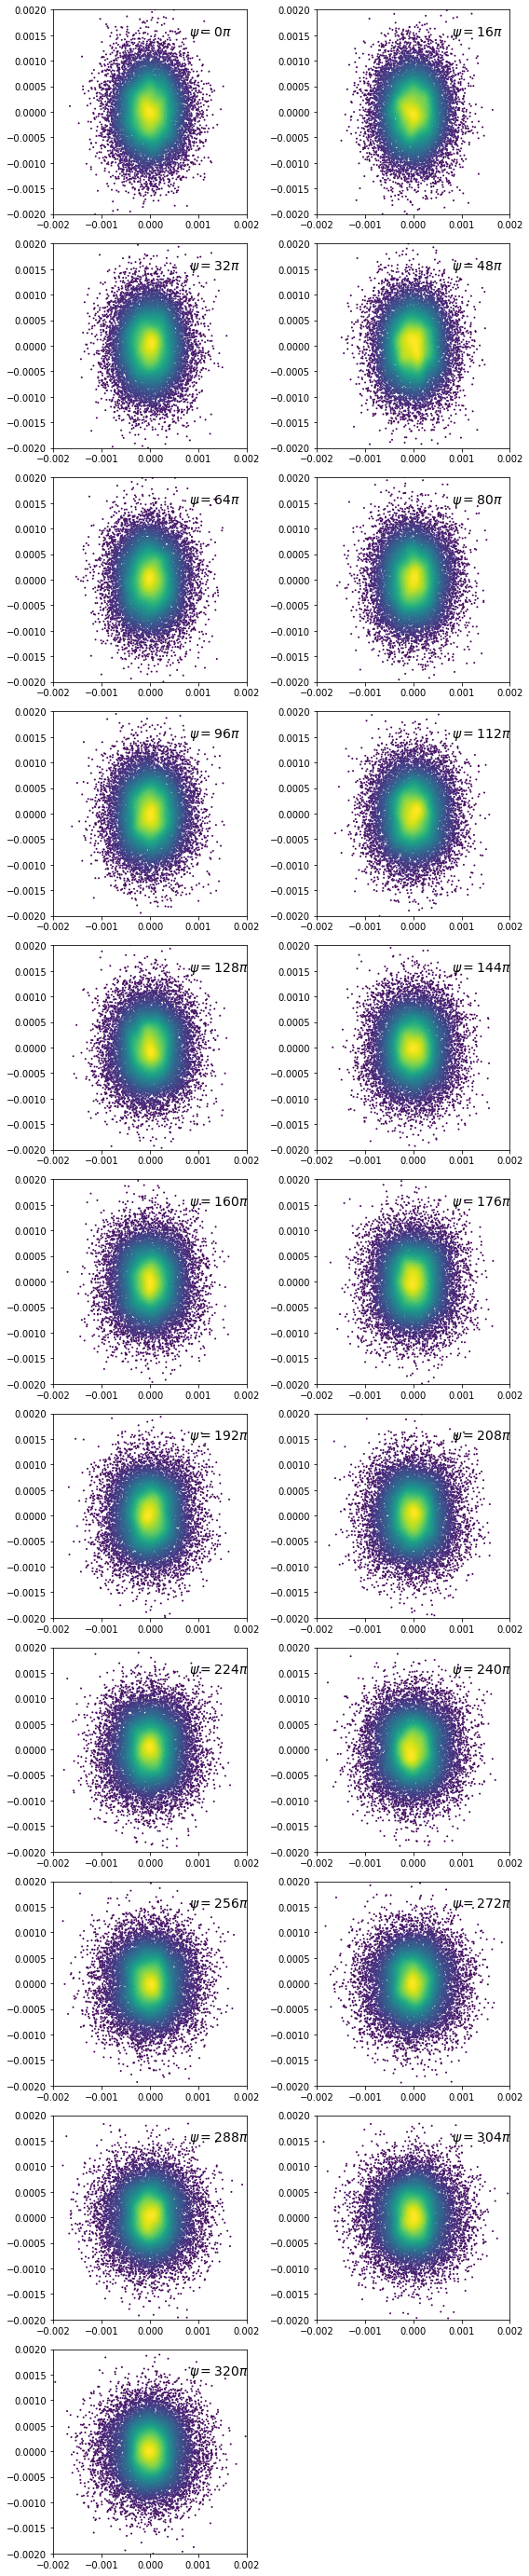

In [41]:
lim = (-2.0*sigx,2.0*sigx)
plt.figure(figsize=(8,ceil((n/16+1)/2)*3.5))
for i in range(0,n+1,16):
    plt.subplot(int(n/32)+1,2,i/16+1)
    impact.plot.poincare(pData[i][:,0],pData[i][:,2],samplePeriod=10,xlim=lim,ylim=lim)
    plt.text(0.0008,0.0015,r'$\psi=$'+str(i)+'$\pi$',fontsize=14)
plt.tight_layout()
plt.savefig('I'+str(Icur)+'mA.png')

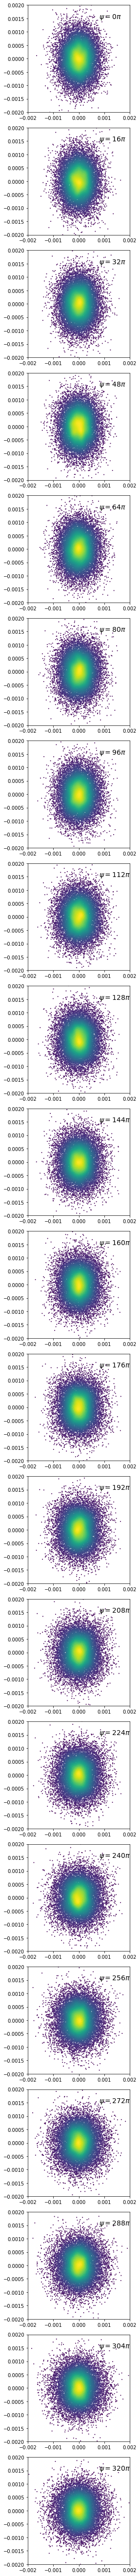

In [53]:
lim = (-2.0*sigx,2.0*sigx)
plt.figure(figsize=(4,ceil(n/16+1)*3.5))
for i in range(0,n+1,16):
    plt.subplot(int(n/16)+1,1,i/16+1)
    impact.plot.poincare(pData[i][:,0],pData[i][:,2],samplePeriod=10,xlim=lim,ylim=lim)
    plt.text(0.0008,0.0015,r'$\psi=$'+str(i)+'$\pi$',fontsize=14)
plt.tight_layout()
plt.savefig('vertical.I'+str(Icur)+'mA.png')

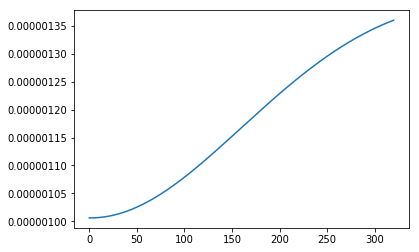

In [52]:
plt.plot(statData['emitx'])

In [65]:
print(statData['emitx'][-1]*bg,statData['emitx'][-2]*bg)

9.93840555027765e-08 9.933642492217642e-08
